In [1]:
from keras.utils import np_utils
import numpy as np
import tensorflow as tf
import os
from PIL import Image
from PIL import ImageFilter
import image_utils as iu
import uuid
from shutil import copy2
import xml.etree.ElementTree as et
import object_detection_utils as odu

In [38]:
data_path = 'data'
object_detection_path = os.path.join(data_path, 'object-detection')
# segmentation_path = os.path.join(data_path, 'segmentation')
#Mining 1 contains satellite images from Google Earth taken with screenshots.
# mining_path = os.path.join(segmentation_path, 'mining')
# divided images
object_detection_original_data_path = os.path.join(object_detection_path, 'object-detection-original')
# mining_real_divided_data_path = os.path.join(mining_divided_data_path, 'real')
# mining_mask_divided_data_path = os.path.join(mining_divided_data_path, 'mask')
# classification images
object_detection_divided_data_path = os.path.join(
    object_detection_path, 'object-detection-divided')
#Labeled data
object_detection_labeled_data_path = os.path.join(object_detection_path, 'object-detection-labeled')
object_detection_labeled_image_data_path = os.path.join(object_detection_labeled_data_path, 'images')
object_detection_labeled_annotation_data_path = os.path.join(object_detection_labeled_data_path, 'annotations')
#
object_detection_aug_data_path = os.path.join(object_detection_path, 'object-detection-labeled-aug')
object_detection_labeled_aug_image_data_path = os.path.join(object_detection_aug_data_path, 'images')
object_detection_labeled_aug_annotation_data_path = os.path.join(object_detection_aug_data_path, 'annotations')
#
SETUP_PATH = 'Tensorflow'
WORKSPACE_PATH = os.path.join(SETUP_PATH, 'workspace')
IMAGE_PATH = os.path.join(WORKSPACE_PATH, 'images')
train_path = os.path.join(IMAGE_PATH, 'train')
test_path = os.path.join(IMAGE_PATH, 'test')
# mining_site_divided_path = os.path.join(
#     classification_divided_data_path, 'mining-site')
# others_divided_path = os.path.join(classification_divided_data_path, 'others')
# #
# classification_final_data_path = os.path.join(
#     classification_path, 'classification-final')
# mining_site_final_path = os.path.join(
#     classification_final_data_path,  'mining-site')
# others_final_data_path = os.path.join(classification_final_data_path, 'others')
#train
# training_path = os.path.join(classification_path, 'training')
# train_path = os.path.join(training_path, 'train')
# train_mining_site_path = os.path.join(train_path, 'mining-site')
# train_others_path = os.path.join(train_path, 'others')
# #val
# val_path = os.path.join(training_path, 'val')
# val_mining_site_path = os.path.join(val_path, 'mining-site')
# val_others_path = os.path.join(val_path, 'others')


In [ ]:
charcoal_images_path = iu.get_all_files(
    object_detection_original_data_path, True)


In [19]:
# Splits image into specified rows and columns
def split_image(image, row_count, col_count):
    parts = []
    width, height = image.size
    left = 0
    top = 0
    right = width / col_count
    bottom = height / row_count
    for r in range(row_count):
        top = int(r * (height / row_count))
        bottom = int(top + (height / row_count))
        for c in range(col_count):
            left = int(c * (width / col_count))
            right = int(left + (width / col_count))
            part = image.crop((left, top, right, bottom))
            parts.append(part)
    return parts

In [28]:
# images are divided into 9 parts and saved on disk.
# This reduces the dimension of the images and also increases the training data.
iu.create_dir_if_not_exists(object_detection_divided_data_path)
for charcoal_image in charcoal_images_path:
    row_count = 25
    col_count = 12
    row_count = 8
    col_count = 4
    row_count = 14
    col_count = 20
    part_count = col_count * row_count
    real_image = iu.read_image(charcoal_image, 'RGB')
    real_image_parts = split_image(real_image, row_count, col_count)
    count = 0
    for x in range(part_count):
        # part_filename = str(uuid.uuid4()) + '.jpg'
        part_filename = str(count) + '.jpg'
        real_image_part = real_image_parts[x]
        real_image_part = real_image_part.resize((320, 320))
        real_image_part.save(os.path.join(
            object_detection_divided_data_path, part_filename))
        count = count + 1


## Prepare Labeled Data

In [3]:
# stores the path of an image and a mask pair
class DataLabelPair:
    def __init__(self, data_real_path, label_path):
        self.data_real_path = data_real_path
        self.label_path = label_path


In [14]:
charcoal_label_images_path = iu.get_all_files(object_detection_labeled_annotation_data_path, '*.xml')

In [16]:
# Gets the file path of real images and its mask pair.
charcoal_data = []
for path in charcoal_label_images_path:
    mining_image = DataLabelPair(os.path.join(
        object_detection_labeled_image_data_path, path.replace('.xml', '.jpg')), os.path.join(object_detection_labeled_annotation_data_path, path))
    charcoal_data.append(mining_image)


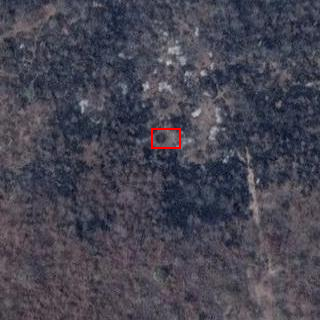

In [23]:
indx = 103
im = iu.read_image(charcoal_data[indx].data_real_path)
bboxesInfo = odu.read_xml(charcoal_data[indx].label_path)[3]
rects = []
for bboxInfo in bboxesInfo:
    rects.append(odu.get_rect(bboxInfo[1]))
odu.plot_rect(im, rects, (255, 0,0), 2)

Augment data

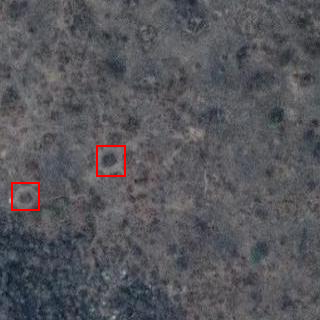

In [8]:
fl_im, fl_bboxes_info = odu.flip_labeled_image_left_right(im, bboxesInfo)
fl_rects = []
for bboxInfo in fl_bboxes_info:
    fl_rects.append(odu.get_rect(bboxInfo[1]))
odu.plot_rect(fl_im, fl_rects, (255, 0, 0), 2)


In [12]:
def get_bbox_info_from_xml(path):
    bboxesInfo = odu.read_xml(path)[3]
    rects = []
    for bboxInfo in bboxesInfo:
        rects.append(odu.get_rect(bboxInfo[1]))
    return rects

def aug_data(data_pair: DataLabelPair):
    images_augmented = []
    image = iu.read_image(data_pair.data_real_path)
    bboxes_info = odu.read_xml(data_pair.label_path)[3]
    images_augmented.append((image, bboxes_info))
    images_augmented.append(odu.rotate_labeled_image(image, 90, bboxes_info))
    images_augmented.append(odu.rotate_labeled_image(image, 180, bboxes_info))
    images_augmented.append(odu.rotate_labeled_image(image, 270, bboxes_info))
    image, bboxes_info = odu.flip_labeled_image_left_right(image, bboxes_info)
    images_augmented.append((image, bboxes_info))
    images_augmented.append(odu.rotate_labeled_image(image, 90, bboxes_info))
    images_augmented.append(odu.rotate_labeled_image(image, 180, bboxes_info))
    images_augmented.append(odu.rotate_labeled_image(image, 270, bboxes_info))
    return images_augmented


In [ ]:
# images are augmented and saved on disk.
iu.create_dir_if_not_exists(object_detection_aug_data_path)
iu.create_dir_if_not_exists(object_detection_labeled_aug_image_data_path)
iu.create_dir_if_not_exists(object_detection_labeled_aug_annotation_data_path)
for data in charcoal_data:
    # real_image = iu.read_image(data.data_real_path, 'RGB')
    annotation = odu.read_xml(data.label_path)
    folder, filename, image_dimen, bbox_info  = annotation
    # bboxes_info = annotation[3]
    data_aug = aug_data(data)
    for x in range(len(data_aug)):
        part_filename = str(uuid.uuid4())
        real_image = data_aug[x][0]
        bboxes_info = data_aug[x][1]
        #
        real_image.save(os.path.join(
            object_detection_labeled_aug_image_data_path, part_filename + '.jpg'))
        odu.write_xml(os.path.join(
            object_detection_labeled_aug_annotation_data_path, part_filename + '.xml'), 
                      folder, part_filename, '/images',image_dimen, bboxes_info)


In [24]:
charcoal_label_aug_images_path = iu.get_all_files(object_detection_labeled_aug_annotation_data_path, '*.xml')

In [31]:
# Gets the file path of real images and its mask pair.
charcoal_aug_data = []
for path in charcoal_label_aug_images_path:
    mining_image = DataLabelPair(os.path.join(
        object_detection_labeled_aug_image_data_path, path.replace('.xml', '.jpg')), os.path.join(object_detection_labeled_aug_annotation_data_path, path))
    charcoal_aug_data.append(mining_image)


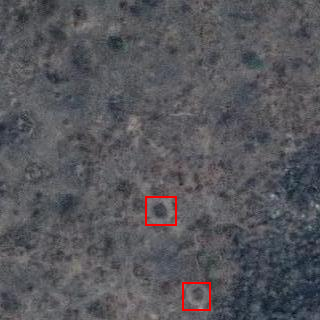

In [34]:
indx = 150
im = iu.read_image(charcoal_aug_data[indx].data_real_path)
bboxesInfo = odu.read_xml(charcoal_data[indx].label_path)[3]
rects = []
for bboxInfo in bboxesInfo:
    rects.append(odu.get_rect(bboxInfo[1]))
odu.plot_rect(im, rects, (255, 0, 0), 2)

In [35]:
# Splits dataset into training, validation and test sets.
def train_val_test_split(val_per, test_per, input_data, labels=None):
    if labels is not None and len(input_data) != len(labels):
        raise Exception("input data and label length mismatch")
    data_len = len(input_data)
    val_len = int(data_len * (val_per / 100))
    test_len = int(data_len * (test_per / 100))
    x_val = input_data[0: val_len]
    x_test = input_data[val_len: val_len + test_len]
    x_train = input_data[val_len + test_len: data_len]
    if labels is not None:
        y_val = labels[0: val_len]
        y_test = labels[val_len: val_len + test_len]
        y_train = labels[val_len + test_len: data_len]
        return (x_train, y_train), (x_val, y_val), (x_test, y_test)
    else:
        return x_train, x_val, x_test


In [36]:
train_images, val_images, test_images = train_val_test_split(10, 0, charcoal_aug_data)
print('Train length:', len(train_images))
print('Val length:', len(val_images))
print('Test length', len(test_images))


Train length: 152
Val length: 16
Test length 0


In [39]:
iu.create_dir_if_not_exists(train_path)
iu.create_dir_if_not_exists(test_path)

In [40]:
# copy training images to training folder
for train_data in train_images:
    copy2(train_data.data_real_path, os.path.join(
        train_path, os.path.basename(train_data.data_real_path)))
    copy2(train_data.label_path, os.path.join(
        train_path, os.path.basename(train_data.label_path)))


In [42]:
# copy training images to training folder
for val_data in val_images:
    copy2(val_data.data_real_path, os.path.join(
        test_path, os.path.basename(val_data.data_real_path)))
    copy2(val_data.label_path, os.path.join(
        test_path, os.path.basename(val_data.label_path)))
